# Download Data

In [1]:
# !gdown 1TyyL4vZb3ksDInS6lj-q1QutA154a29F
# !gdown 1tHLmGAV0SqMGMqkNij40VFZvlHqKyilz
# !gdown 1wLxJvRGGiYq4_pXoqiYaQRGT5wQhC04f
# !gdown 1k6kgwQEOBwkRDRTv2Bw-77UYZlbqk--n

In [ ]:
# !pip freeze > requirements2.txt

In [1]:
# !pip install msvc-runtime
import os
import sys
os.path.dirname(sys.executable)


'c:\\Users\\tld\\.conda\\envs\\vit_env'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, DatasetDict, Features, ClassLabel, Array3D

# Read Data

In [4]:
train_X = np.load('driving_train_images.npy')
train_y = np.load('driving_train_labels.npy')
test_X = np.load('driving_data_test_images.npy')
test_y = np.load('driving_data_test_labels.npy')

In [5]:
print("Train Images", train_X.shape)
print("Train Labels", train_y.shape)

Train Images (3511, 256, 256, 1)
Train Labels (3511, 3)


In [ ]:
print("Test Images", test_X.shape)

print("Test Labels", test_y.shape)

Test Images (938, 256, 256, 1)
Test Labels (938, 3)


In [7]:
labels = ["angry", "happy", "neutral"]

## Visualize Images

In [8]:
def show(idx):
    plt.figure(figsize=(10, 6))
    plt.imshow(train_X[idx], cmap="gray")
    plt.title(labels[np.argmax(train_y[idx])])
    plt.axis("off")
    plt.show()

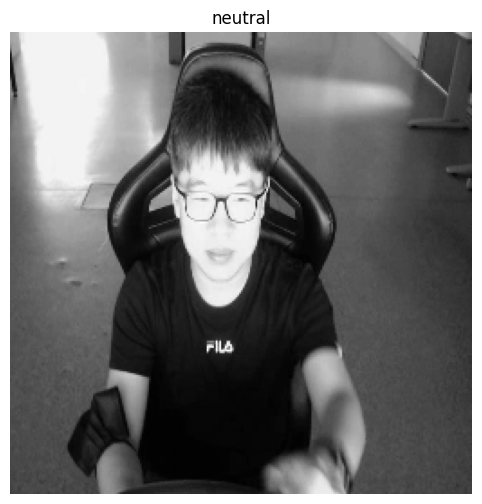

In [21]:
show(np.random.randint(len(train_X)))

## Convert to HuggingFace dataset

In [23]:
train_data = [{"image": img, "label": np.argmax(label)} for img, label in zip(train_X, train_y)]
test_data = [{"image": img, "label": np.argmax(label)} for img, label in zip(test_X, test_y)]

train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

features = Features({
    "image": Array3D(dtype="float32", shape=train_X[0].shape),
    "label": ClassLabel(num_classes=len(labels), names=labels),
})

train_dataset = train_dataset.cast(features)
test_dataset = test_dataset.cast(features)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

print(dataset)

Casting the dataset: 100%|██████████| 938/938 [00:00<00:00, 4962.99 examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3511
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 938
    })
})


In [27]:
np.array(dataset['train'][0]['image']).shape

(256, 256, 1)

## Save Dataset

In [28]:
dataset.save_to_disk("./driving_dataset")

Saving the dataset (1/1 shards): 100%|██████████| 938/938 [00:00<00:00, 3061.09 examples/s]


# Vision Transformer

In [2]:
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import Trainer, TrainingArguments
from evaluate import load as load_metric
from datasets import Dataset, DatasetDict
import numpy as np
import torch

c:\Users\tld\.conda\envs\vit_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [4]:
dataset = DatasetDict.load_from_disk('./driving_dataset')
labels = ["angry", "happy", "neutral"]

In [5]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_data(examples):
    images = [np.stack([np.clip(np.array(img), 0, 1).squeeze(-1)] * 3, axis=-1) for img in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="pt", do_rescale=False, )
    inputs["label"] = examples["label"]
    return inputs

In [6]:
dataset = dataset.map(preprocess_data, batched=True)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 3511
    })
    test: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 938
    })
})

## Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# accuracy_metric = load_metric("accuracy")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = logits.argmax(axis=-1)
#     return accuracy_metric.compute(predictions=predictions, references=labels)

# training_args = TrainingArguments(
#     output_dir="./vit-finetuning",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     report_to="none",
# )

# train_dataset = dataset["train"].with_format("torch")
# test_dataset = dataset["test"].with_format("torch")

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,
# )

In [10]:
# Initialize accuracy metric
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    
    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    
    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    # Return both metrics
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }
# Training arguments template
training_args_template = {
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "learning_rate": 5e-5,
    "per_device_train_batch_size": 64,
    "per_device_eval_batch_size": 64,
    "num_train_epochs": 10,
    "weight_decay": 0.01,
    "load_best_model_at_end": True,
    "metric_for_best_model": "accuracy",
    "report_to": "none",
}

# Load datasets
train_dataset = dataset["train"].with_format("torch")
test_dataset = dataset["test"].with_format("torch")



In [11]:
# Sample sizes to train on
sample_sizes = range(100, 900, 100)

# Store results for each sample size
results = []

for sample_size in sample_sizes:
    # Subset the train dataset to the desired size
    sampled_train_dataset = train_dataset.select(np.random.choice(len(train_dataset), sample_size, replace=False))
    
    # Configure training arguments
    training_args = TrainingArguments(
        **training_args_template,
        output_dir=f"C:\\Users\\tld\\Downloads\\cs5805project\\VIT fineTune f1\\vit-finetuning-{sample_size}"
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=sampled_train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate the model
    eval_results = trainer.evaluate()
    
    # Save the results
    results.append({"sample_size": sample_size, "eval_results": eval_results})
    print(f"Finished training with {sample_size} samples.")

# Print all results
for result in results:
    print(f"Sample Size: {result['sample_size']}, Evaluation Results: {result['eval_results']}")

                                              
 10%|█         | 2/20 [00:24<01:06,  3.67s/it] 

{'eval_loss': 1.1057729721069336, 'eval_accuracy': 0.3624733475479744, 'eval_f1': 0.2182944427145526, 'eval_runtime': 15.8281, 'eval_samples_per_second': 59.262, 'eval_steps_per_second': 0.948, 'epoch': 1.0}


                                              
 20%|██        | 4/20 [00:49<02:12,  8.28s/it] 

{'eval_loss': 1.1123332977294922, 'eval_accuracy': 0.36140724946695096, 'eval_f1': 0.2030830347633429, 'eval_runtime': 16.0851, 'eval_samples_per_second': 58.315, 'eval_steps_per_second': 0.933, 'epoch': 2.0}


                                              
 30%|███       | 6/20 [01:14<02:15,  9.66s/it] 

{'eval_loss': 1.1188011169433594, 'eval_accuracy': 0.36886993603411516, 'eval_f1': 0.22255491695772486, 'eval_runtime': 16.0744, 'eval_samples_per_second': 58.354, 'eval_steps_per_second': 0.933, 'epoch': 3.0}


                                              
 40%|████      | 8/20 [01:39<02:02, 10.20s/it] 

{'eval_loss': 1.1232045888900757, 'eval_accuracy': 0.3752665245202559, 'eval_f1': 0.26457654300923134, 'eval_runtime': 15.8889, 'eval_samples_per_second': 59.035, 'eval_steps_per_second': 0.944, 'epoch': 4.0}


                                               
 50%|█████     | 10/20 [02:04<01:43, 10.40s/it]

{'eval_loss': 1.1238274574279785, 'eval_accuracy': 0.4189765458422175, 'eval_f1': 0.3325461606043551, 'eval_runtime': 15.7354, 'eval_samples_per_second': 59.611, 'eval_steps_per_second': 0.953, 'epoch': 5.0}


                                               
 60%|██████    | 12/20 [02:29<01:23, 10.46s/it]

{'eval_loss': 1.1257625818252563, 'eval_accuracy': 0.4211087420042644, 'eval_f1': 0.3352536002999184, 'eval_runtime': 15.7729, 'eval_samples_per_second': 59.469, 'eval_steps_per_second': 0.951, 'epoch': 6.0}


                                               
 70%|███████   | 14/20 [02:53<01:02, 10.50s/it]

{'eval_loss': 1.126314401626587, 'eval_accuracy': 0.43390191897654584, 'eval_f1': 0.35511241447972547, 'eval_runtime': 15.8041, 'eval_samples_per_second': 59.352, 'eval_steps_per_second': 0.949, 'epoch': 7.0}


                                               
 80%|████████  | 16/20 [03:18<00:42, 10.53s/it]

{'eval_loss': 1.126122236251831, 'eval_accuracy': 0.44243070362473347, 'eval_f1': 0.36903546868155374, 'eval_runtime': 15.9088, 'eval_samples_per_second': 58.961, 'eval_steps_per_second': 0.943, 'epoch': 8.0}


                                               
 90%|█████████ | 18/20 [03:43<00:21, 10.56s/it]

{'eval_loss': 1.1255964040756226, 'eval_accuracy': 0.44029850746268656, 'eval_f1': 0.3691256504689341, 'eval_runtime': 15.8181, 'eval_samples_per_second': 59.299, 'eval_steps_per_second': 0.948, 'epoch': 9.0}


                                               
100%|██████████| 20/20 [04:09<00:00, 10.56s/it]

{'eval_loss': 1.1251451969146729, 'eval_accuracy': 0.44136460554371004, 'eval_f1': 0.37056123421849574, 'eval_runtime': 15.844, 'eval_samples_per_second': 59.202, 'eval_steps_per_second': 0.947, 'epoch': 10.0}


100%|██████████| 20/20 [04:10<00:00, 12.51s/it]


{'train_runtime': 250.233, 'train_samples_per_second': 3.996, 'train_steps_per_second': 0.08, 'train_loss': 0.8447149276733399, 'epoch': 10.0}


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Finished training with 100 samples.


 10%|█         | 4/40 [00:26<01:57,  3.26s/it] 

{'eval_loss': 1.0753319263458252, 'eval_accuracy': 0.4189765458422175, 'eval_f1': 0.40403902010257864, 'eval_runtime': 10.3025, 'eval_samples_per_second': 91.045, 'eval_steps_per_second': 1.456, 'epoch': 1.0}


 20%|██        | 8/40 [00:54<02:28,  4.66s/it] 

{'eval_loss': 1.0655852556228638, 'eval_accuracy': 0.4157782515991471, 'eval_f1': 0.33912322043006776, 'eval_runtime': 10.4431, 'eval_samples_per_second': 89.82, 'eval_steps_per_second': 1.436, 'epoch': 2.0}


 30%|███       | 12/40 [01:23<02:17,  4.92s/it]

{'eval_loss': 1.0239379405975342, 'eval_accuracy': 0.5074626865671642, 'eval_f1': 0.4820531377888658, 'eval_runtime': 10.2866, 'eval_samples_per_second': 91.187, 'eval_steps_per_second': 1.458, 'epoch': 3.0}


 40%|████      | 16/40 [01:51<01:58,  4.95s/it]

{'eval_loss': 1.0091674327850342, 'eval_accuracy': 0.5149253731343284, 'eval_f1': 0.49666729804247683, 'eval_runtime': 10.2896, 'eval_samples_per_second': 91.16, 'eval_steps_per_second': 1.458, 'epoch': 4.0}


 50%|█████     | 20/40 [02:19<01:39,  4.97s/it]

{'eval_loss': 0.9985741972923279, 'eval_accuracy': 0.5159914712153518, 'eval_f1': 0.49587986288368696, 'eval_runtime': 10.2378, 'eval_samples_per_second': 91.622, 'eval_steps_per_second': 1.465, 'epoch': 5.0}


 60%|██████    | 24/40 [02:48<01:19,  4.96s/it]

{'eval_loss': 0.9778681993484497, 'eval_accuracy': 0.5309168443496801, 'eval_f1': 0.5065593856007916, 'eval_runtime': 10.3942, 'eval_samples_per_second': 90.242, 'eval_steps_per_second': 1.443, 'epoch': 6.0}


 70%|███████   | 28/40 [03:17<01:00,  5.00s/it]

{'eval_loss': 0.9609567523002625, 'eval_accuracy': 0.5607675906183369, 'eval_f1': 0.5502321903158849, 'eval_runtime': 10.3903, 'eval_samples_per_second': 90.277, 'eval_steps_per_second': 1.444, 'epoch': 7.0}


 80%|████████  | 32/40 [03:46<00:40,  5.04s/it]

{'eval_loss': 0.9540351629257202, 'eval_accuracy': 0.5628997867803838, 'eval_f1': 0.551845106140118, 'eval_runtime': 10.3623, 'eval_samples_per_second': 90.52, 'eval_steps_per_second': 1.448, 'epoch': 8.0}


 90%|█████████ | 36/40 [04:15<00:20,  5.05s/it]

{'eval_loss': 0.9470294117927551, 'eval_accuracy': 0.5639658848614072, 'eval_f1': 0.5509828680675327, 'eval_runtime': 10.3095, 'eval_samples_per_second': 90.984, 'eval_steps_per_second': 1.455, 'epoch': 9.0}


100%|██████████| 40/40 [04:44<00:00,  5.04s/it]

{'eval_loss': 0.9436952471733093, 'eval_accuracy': 0.5671641791044776, 'eval_f1': 0.5540003952924358, 'eval_runtime': 10.4259, 'eval_samples_per_second': 89.968, 'eval_steps_per_second': 1.439, 'epoch': 10.0}


100%|██████████| 40/40 [04:45<00:00,  7.14s/it]


{'train_runtime': 285.7052, 'train_samples_per_second': 7.0, 'train_steps_per_second': 0.14, 'train_loss': 0.7623106956481933, 'epoch': 10.0}


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


Finished training with 200 samples.


 10%|█         | 5/50 [00:19<01:15,  1.67s/it] 

{'eval_loss': 0.8517070412635803, 'eval_accuracy': 0.6353944562899787, 'eval_f1': 0.6145598312996087, 'eval_runtime': 9.1205, 'eval_samples_per_second': 102.845, 'eval_steps_per_second': 1.645, 'epoch': 1.0}


 20%|██        | 10/50 [00:37<01:28,  2.21s/it]

{'eval_loss': 0.8073005676269531, 'eval_accuracy': 0.6396588486140725, 'eval_f1': 0.6309337471993605, 'eval_runtime': 9.0756, 'eval_samples_per_second': 103.354, 'eval_steps_per_second': 1.653, 'epoch': 2.0}


 30%|███       | 15/50 [00:55<01:20,  2.29s/it]

{'eval_loss': 0.7438914179801941, 'eval_accuracy': 0.6812366737739872, 'eval_f1': 0.6536184164247019, 'eval_runtime': 9.1075, 'eval_samples_per_second': 102.992, 'eval_steps_per_second': 1.647, 'epoch': 3.0}


 40%|████      | 20/50 [01:13<01:08,  2.29s/it]

{'eval_loss': 0.7875372767448425, 'eval_accuracy': 0.6396588486140725, 'eval_f1': 0.632652185938709, 'eval_runtime': 9.258, 'eval_samples_per_second': 101.317, 'eval_steps_per_second': 1.62, 'epoch': 4.0}


 50%|█████     | 25/50 [01:32<00:57,  2.30s/it]

{'eval_loss': 0.7176941633224487, 'eval_accuracy': 0.6769722814498934, 'eval_f1': 0.6722656098496255, 'eval_runtime': 9.1145, 'eval_samples_per_second': 102.913, 'eval_steps_per_second': 1.646, 'epoch': 5.0}


 60%|██████    | 30/50 [01:50<00:45,  2.29s/it]

{'eval_loss': 0.7802059650421143, 'eval_accuracy': 0.6471215351812367, 'eval_f1': 0.6383696093133586, 'eval_runtime': 9.1315, 'eval_samples_per_second': 102.722, 'eval_steps_per_second': 1.643, 'epoch': 6.0}


 70%|███████   | 35/50 [02:08<00:34,  2.29s/it]

{'eval_loss': 0.7202903032302856, 'eval_accuracy': 0.6844349680170576, 'eval_f1': 0.6806140319690114, 'eval_runtime': 9.1783, 'eval_samples_per_second': 102.198, 'eval_steps_per_second': 1.634, 'epoch': 7.0}


 80%|████████  | 40/50 [02:26<00:22,  2.29s/it]

{'eval_loss': 0.7421306371688843, 'eval_accuracy': 0.673773987206823, 'eval_f1': 0.6718543629114938, 'eval_runtime': 9.1484, 'eval_samples_per_second': 102.532, 'eval_steps_per_second': 1.64, 'epoch': 8.0}


 90%|█████████ | 45/50 [02:45<00:11,  2.30s/it]

{'eval_loss': 0.7573888897895813, 'eval_accuracy': 0.6599147121535182, 'eval_f1': 0.6574922485775689, 'eval_runtime': 9.314, 'eval_samples_per_second': 100.708, 'eval_steps_per_second': 1.61, 'epoch': 9.0}


100%|██████████| 50/50 [03:04<00:00,  2.31s/it]

{'eval_loss': 0.7512633800506592, 'eval_accuracy': 0.673773987206823, 'eval_f1': 0.6711508700875541, 'eval_runtime': 9.2072, 'eval_samples_per_second': 101.877, 'eval_steps_per_second': 1.629, 'epoch': 10.0}


100%|██████████| 50/50 [03:05<00:00,  3.70s/it]


{'train_runtime': 185.0456, 'train_samples_per_second': 16.212, 'train_steps_per_second': 0.27, 'train_loss': 0.2977782440185547, 'epoch': 10.0}


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


Finished training with 300 samples.


 10%|█         | 7/70 [00:17<00:56,  1.11it/s] 

{'eval_loss': 0.6820842623710632, 'eval_accuracy': 0.7004264392324094, 'eval_f1': 0.6971836631938549, 'eval_runtime': 9.2092, 'eval_samples_per_second': 101.855, 'eval_steps_per_second': 1.629, 'epoch': 1.0}


 20%|██        | 14/70 [00:35<01:09,  1.24s/it]

{'eval_loss': 0.706448495388031, 'eval_accuracy': 0.6961620469083155, 'eval_f1': 0.6893506841278997, 'eval_runtime': 9.2152, 'eval_samples_per_second': 101.789, 'eval_steps_per_second': 1.628, 'epoch': 2.0}


 30%|███       | 21/70 [00:53<01:02,  1.27s/it]

{'eval_loss': 0.6460363268852234, 'eval_accuracy': 0.7409381663113006, 'eval_f1': 0.7429347714025757, 'eval_runtime': 9.26, 'eval_samples_per_second': 101.296, 'eval_steps_per_second': 1.62, 'epoch': 3.0}


 40%|████      | 28/70 [01:11<00:53,  1.28s/it]

{'eval_loss': 0.6431429982185364, 'eval_accuracy': 0.753731343283582, 'eval_f1': 0.7489246730289676, 'eval_runtime': 9.2401, 'eval_samples_per_second': 101.514, 'eval_steps_per_second': 1.623, 'epoch': 4.0}


 50%|█████     | 35/70 [01:30<00:44,  1.28s/it]

{'eval_loss': 0.7014726400375366, 'eval_accuracy': 0.732409381663113, 'eval_f1': 0.7319502979279037, 'eval_runtime': 9.2491, 'eval_samples_per_second': 101.416, 'eval_steps_per_second': 1.622, 'epoch': 5.0}


 60%|██████    | 42/70 [01:48<00:36,  1.29s/it]

{'eval_loss': 0.677193820476532, 'eval_accuracy': 0.7515991471215352, 'eval_f1': 0.7501372272999925, 'eval_runtime': 9.3687, 'eval_samples_per_second': 100.121, 'eval_steps_per_second': 1.601, 'epoch': 6.0}


 70%|███████   | 49/70 [02:06<00:26,  1.28s/it]

{'eval_loss': 0.7044416069984436, 'eval_accuracy': 0.7452025586353944, 'eval_f1': 0.7443080707730604, 'eval_runtime': 9.2441, 'eval_samples_per_second': 101.47, 'eval_steps_per_second': 1.623, 'epoch': 7.0}


 80%|████████  | 56/70 [02:25<00:17,  1.28s/it]

{'eval_loss': 0.6842134594917297, 'eval_accuracy': 0.755863539445629, 'eval_f1': 0.7522687767965193, 'eval_runtime': 9.2421, 'eval_samples_per_second': 101.492, 'eval_steps_per_second': 1.623, 'epoch': 8.0}


 90%|█████████ | 63/70 [02:43<00:09,  1.29s/it]

{'eval_loss': 0.6781581044197083, 'eval_accuracy': 0.7601279317697228, 'eval_f1': 0.7575949902861107, 'eval_runtime': 9.267, 'eval_samples_per_second': 101.219, 'eval_steps_per_second': 1.619, 'epoch': 9.0}


100%|██████████| 70/70 [03:02<00:00,  1.29s/it]

{'eval_loss': 0.6802899241447449, 'eval_accuracy': 0.755863539445629, 'eval_f1': 0.753846838732239, 'eval_runtime': 9.2919, 'eval_samples_per_second': 100.948, 'eval_steps_per_second': 1.614, 'epoch': 10.0}


100%|██████████| 70/70 [03:03<00:00,  2.62s/it]


{'train_runtime': 183.3441, 'train_samples_per_second': 21.817, 'train_steps_per_second': 0.382, 'train_loss': 0.12060680389404296, 'epoch': 10.0}


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


Finished training with 400 samples.


 10%|█         | 8/80 [00:19<01:24,  1.18s/it] 

{'eval_loss': 0.6834468841552734, 'eval_accuracy': 0.7366737739872068, 'eval_f1': 0.7392805404129597, 'eval_runtime': 9.2947, 'eval_samples_per_second': 100.917, 'eval_steps_per_second': 1.614, 'epoch': 1.0}


 20%|██        | 16/80 [00:40<01:30,  1.42s/it]

{'eval_loss': 0.5913222432136536, 'eval_accuracy': 0.7889125799573561, 'eval_f1': 0.785045992832286, 'eval_runtime': 9.557, 'eval_samples_per_second': 98.148, 'eval_steps_per_second': 1.57, 'epoch': 2.0}


 30%|███       | 24/80 [01:01<01:21,  1.45s/it]

{'eval_loss': 0.6577847003936768, 'eval_accuracy': 0.7569296375266524, 'eval_f1': 0.759724849885638, 'eval_runtime': 9.1923, 'eval_samples_per_second': 102.042, 'eval_steps_per_second': 1.632, 'epoch': 3.0}


 40%|████      | 32/80 [01:21<01:08,  1.43s/it]

{'eval_loss': 0.643408477306366, 'eval_accuracy': 0.7739872068230277, 'eval_f1': 0.7750219806743763, 'eval_runtime': 9.3587, 'eval_samples_per_second': 100.228, 'eval_steps_per_second': 1.603, 'epoch': 4.0}


 50%|█████     | 40/80 [01:42<00:57,  1.43s/it]

{'eval_loss': 0.6515042185783386, 'eval_accuracy': 0.7899786780383795, 'eval_f1': 0.7918871805817456, 'eval_runtime': 9.4743, 'eval_samples_per_second': 99.005, 'eval_steps_per_second': 1.583, 'epoch': 5.0}


 60%|██████    | 48/80 [02:03<00:45,  1.44s/it]

{'eval_loss': 0.6651760339736938, 'eval_accuracy': 0.7771855010660981, 'eval_f1': 0.7769411489959708, 'eval_runtime': 9.3218, 'eval_samples_per_second': 100.624, 'eval_steps_per_second': 1.609, 'epoch': 6.0}


 70%|███████   | 56/80 [02:23<00:34,  1.43s/it]

{'eval_loss': 0.7569101452827454, 'eval_accuracy': 0.7505330490405118, 'eval_f1': 0.7513822225247317, 'eval_runtime': 9.2431, 'eval_samples_per_second': 101.481, 'eval_steps_per_second': 1.623, 'epoch': 7.0}


 80%|████████  | 64/80 [02:44<00:23,  1.44s/it]

{'eval_loss': 0.6678116917610168, 'eval_accuracy': 0.7867803837953091, 'eval_f1': 0.7868167919058202, 'eval_runtime': 9.5091, 'eval_samples_per_second': 98.642, 'eval_steps_per_second': 1.577, 'epoch': 8.0}


 90%|█████████ | 72/80 [03:05<00:11,  1.45s/it]

{'eval_loss': 0.6560696959495544, 'eval_accuracy': 0.7942430703624733, 'eval_f1': 0.7940746849603818, 'eval_runtime': 9.2501, 'eval_samples_per_second': 101.405, 'eval_steps_per_second': 1.622, 'epoch': 9.0}


100%|██████████| 80/80 [03:26<00:00,  1.43s/it]

{'eval_loss': 0.6593993902206421, 'eval_accuracy': 0.7921108742004265, 'eval_f1': 0.7918064058818247, 'eval_runtime': 9.2281, 'eval_samples_per_second': 101.646, 'eval_steps_per_second': 1.625, 'epoch': 10.0}


100%|██████████| 80/80 [03:27<00:00,  2.59s/it]


{'train_runtime': 207.0317, 'train_samples_per_second': 24.151, 'train_steps_per_second': 0.386, 'train_loss': 0.10558438301086426, 'epoch': 10.0}


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


Finished training with 500 samples.


 10%|█         | 10/100 [00:23<01:30,  1.00s/it]

{'eval_loss': 0.5795256495475769, 'eval_accuracy': 0.7995735607675906, 'eval_f1': 0.7981810250166784, 'eval_runtime': 10.5597, 'eval_samples_per_second': 88.828, 'eval_steps_per_second': 1.42, 'epoch': 1.0}


 20%|██        | 20/100 [00:48<01:30,  1.13s/it]

{'eval_loss': 0.5860746502876282, 'eval_accuracy': 0.7985074626865671, 'eval_f1': 0.8008490543949416, 'eval_runtime': 10.3992, 'eval_samples_per_second': 90.199, 'eval_steps_per_second': 1.442, 'epoch': 2.0}


 30%|███       | 30/100 [01:11<01:19,  1.13s/it]

{'eval_loss': 0.5796637535095215, 'eval_accuracy': 0.8059701492537313, 'eval_f1': 0.808111948040119, 'eval_runtime': 9.3218, 'eval_samples_per_second': 100.624, 'eval_steps_per_second': 1.609, 'epoch': 3.0}


 40%|████      | 40/100 [01:34<01:03,  1.07s/it]

{'eval_loss': 0.6202443242073059, 'eval_accuracy': 0.7995735607675906, 'eval_f1': 0.7980200800972902, 'eval_runtime': 9.273, 'eval_samples_per_second': 101.154, 'eval_steps_per_second': 1.618, 'epoch': 4.0}


 50%|█████     | 50/100 [01:56<00:53,  1.07s/it]

{'eval_loss': 0.6243728399276733, 'eval_accuracy': 0.8081023454157783, 'eval_f1': 0.8061009984670146, 'eval_runtime': 9.3188, 'eval_samples_per_second': 100.656, 'eval_steps_per_second': 1.61, 'epoch': 5.0}


 60%|██████    | 60/100 [02:19<00:42,  1.07s/it]

{'eval_loss': 0.6395280361175537, 'eval_accuracy': 0.8113006396588486, 'eval_f1': 0.8086299465598621, 'eval_runtime': 9.1683, 'eval_samples_per_second': 102.309, 'eval_steps_per_second': 1.636, 'epoch': 6.0}


 70%|███████   | 70/100 [02:41<00:32,  1.07s/it]

{'eval_loss': 0.6450503468513489, 'eval_accuracy': 0.8155650319829424, 'eval_f1': 0.8141802843155761, 'eval_runtime': 9.2072, 'eval_samples_per_second': 101.877, 'eval_steps_per_second': 1.629, 'epoch': 7.0}


 80%|████████  | 80/100 [03:04<00:21,  1.08s/it]

{'eval_loss': 0.6586474180221558, 'eval_accuracy': 0.8166311300639659, 'eval_f1': 0.8152594448279492, 'eval_runtime': 9.3776, 'eval_samples_per_second': 100.025, 'eval_steps_per_second': 1.6, 'epoch': 8.0}


 90%|█████████ | 90/100 [03:27<00:10,  1.07s/it]

{'eval_loss': 0.6545729041099548, 'eval_accuracy': 0.8176972281449894, 'eval_f1': 0.8162186987999174, 'eval_runtime': 9.5634, 'eval_samples_per_second': 98.082, 'eval_steps_per_second': 1.568, 'epoch': 9.0}


100%|██████████| 100/100 [03:50<00:00,  1.08s/it]

{'eval_loss': 0.6522418260574341, 'eval_accuracy': 0.8176972281449894, 'eval_f1': 0.8162588613934447, 'eval_runtime': 9.6317, 'eval_samples_per_second': 97.387, 'eval_steps_per_second': 1.557, 'epoch': 10.0}


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]


{'train_runtime': 231.5438, 'train_samples_per_second': 25.913, 'train_steps_per_second': 0.432, 'train_loss': 0.05666017055511475, 'epoch': 10.0}


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Finished training with 600 samples.


 10%|█         | 11/110 [00:23<01:59,  1.21s/it]

{'eval_loss': 0.6562427878379822, 'eval_accuracy': 0.7878464818763327, 'eval_f1': 0.7873522152933938, 'eval_runtime': 9.3846, 'eval_samples_per_second': 99.951, 'eval_steps_per_second': 1.598, 'epoch': 1.0}


 20%|██        | 22/110 [00:48<01:51,  1.27s/it]

{'eval_loss': 0.5758271217346191, 'eval_accuracy': 0.8081023454157783, 'eval_f1': 0.8075182986137842, 'eval_runtime': 9.2152, 'eval_samples_per_second': 101.789, 'eval_steps_per_second': 1.628, 'epoch': 2.0}


 30%|███       | 33/110 [01:13<01:38,  1.28s/it]

{'eval_loss': 0.550502598285675, 'eval_accuracy': 0.826226012793177, 'eval_f1': 0.8266723596473808, 'eval_runtime': 9.1574, 'eval_samples_per_second': 102.431, 'eval_steps_per_second': 1.638, 'epoch': 3.0}


 40%|████      | 44/110 [01:37<01:23,  1.27s/it]

{'eval_loss': 0.5855283141136169, 'eval_accuracy': 0.837953091684435, 'eval_f1': 0.8365717585307231, 'eval_runtime': 9.2521, 'eval_samples_per_second': 101.383, 'eval_steps_per_second': 1.621, 'epoch': 4.0}


 50%|█████     | 55/110 [02:02<01:09,  1.27s/it]

{'eval_loss': 0.5989434719085693, 'eval_accuracy': 0.837953091684435, 'eval_f1': 0.8359742985559216, 'eval_runtime': 9.1853, 'eval_samples_per_second': 102.12, 'eval_steps_per_second': 1.633, 'epoch': 5.0}


 60%|██████    | 66/110 [02:26<00:56,  1.28s/it]

{'eval_loss': 0.5976532697677612, 'eval_accuracy': 0.8400852878464818, 'eval_f1': 0.8392190409741618, 'eval_runtime': 9.1524, 'eval_samples_per_second': 102.487, 'eval_steps_per_second': 1.639, 'epoch': 6.0}


 70%|███████   | 77/110 [02:51<00:41,  1.27s/it]

{'eval_loss': 0.6005630493164062, 'eval_accuracy': 0.8454157782515992, 'eval_f1': 0.8442044439877854, 'eval_runtime': 9.3302, 'eval_samples_per_second': 100.534, 'eval_steps_per_second': 1.608, 'epoch': 7.0}


 80%|████████  | 88/110 [03:15<00:27,  1.26s/it]

{'eval_loss': 0.6041922569274902, 'eval_accuracy': 0.8422174840085288, 'eval_f1': 0.8413837219526817, 'eval_runtime': 9.0451, 'eval_samples_per_second': 103.703, 'eval_steps_per_second': 1.658, 'epoch': 8.0}


 90%|█████████ | 99/110 [03:40<00:13,  1.27s/it]

{'eval_loss': 0.606920599937439, 'eval_accuracy': 0.8422174840085288, 'eval_f1': 0.8415998629051411, 'eval_runtime': 9.0621, 'eval_samples_per_second': 103.508, 'eval_steps_per_second': 1.655, 'epoch': 9.0}


100%|██████████| 110/110 [04:04<00:00,  1.27s/it]

{'eval_loss': 0.6076777577400208, 'eval_accuracy': 0.8422174840085288, 'eval_f1': 0.8415998629051411, 'eval_runtime': 9.0903, 'eval_samples_per_second': 103.187, 'eval_steps_per_second': 1.65, 'epoch': 10.0}


100%|██████████| 110/110 [04:05<00:00,  2.23s/it]


{'train_runtime': 245.7844, 'train_samples_per_second': 28.48, 'train_steps_per_second': 0.448, 'train_loss': 0.04243754040111195, 'epoch': 10.0}


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Finished training with 700 samples.


 10%|█         | 13/130 [00:25<01:56,  1.00it/s]

{'eval_loss': 0.687147319316864, 'eval_accuracy': 0.82409381663113, 'eval_f1': 0.8212567441178198, 'eval_runtime': 9.052, 'eval_samples_per_second': 103.623, 'eval_steps_per_second': 1.657, 'epoch': 1.0}


 20%|██        | 26/130 [00:51<01:45,  1.01s/it]

{'eval_loss': 0.5940414071083069, 'eval_accuracy': 0.8464818763326226, 'eval_f1': 0.8429697655253606, 'eval_runtime': 8.9813, 'eval_samples_per_second': 104.44, 'eval_steps_per_second': 1.67, 'epoch': 2.0}


 30%|███       | 39/130 [01:17<01:31,  1.01s/it]

{'eval_loss': 0.7699755430221558, 'eval_accuracy': 0.8081023454157783, 'eval_f1': 0.8091707852014837, 'eval_runtime': 8.9063, 'eval_samples_per_second': 105.319, 'eval_steps_per_second': 1.684, 'epoch': 3.0}


 40%|████      | 52/130 [01:43<01:19,  1.01s/it]

{'eval_loss': 0.8179293870925903, 'eval_accuracy': 0.7931769722814499, 'eval_f1': 0.7904916442828378, 'eval_runtime': 8.9199, 'eval_samples_per_second': 105.158, 'eval_steps_per_second': 1.682, 'epoch': 4.0}


 50%|█████     | 65/130 [02:09<01:06,  1.02s/it]

{'eval_loss': 0.7855963706970215, 'eval_accuracy': 0.8049040511727079, 'eval_f1': 0.8052633179261974, 'eval_runtime': 9.146, 'eval_samples_per_second': 102.559, 'eval_steps_per_second': 1.64, 'epoch': 5.0}


 60%|██████    | 78/130 [02:36<00:53,  1.02s/it]

{'eval_loss': 0.6201900243759155, 'eval_accuracy': 0.8400852878464818, 'eval_f1': 0.8398596975026402, 'eval_runtime': 9.1876, 'eval_samples_per_second': 102.094, 'eval_steps_per_second': 1.633, 'epoch': 6.0}


 70%|███████   | 91/130 [03:03<00:40,  1.03s/it]

{'eval_loss': 0.6466854214668274, 'eval_accuracy': 0.8422174840085288, 'eval_f1': 0.8388651481060788, 'eval_runtime': 9.4763, 'eval_samples_per_second': 98.984, 'eval_steps_per_second': 1.583, 'epoch': 7.0}


 80%|████████  | 104/130 [03:29<00:26,  1.03s/it]

{'eval_loss': 0.6431248188018799, 'eval_accuracy': 0.8432835820895522, 'eval_f1': 0.840427014125128, 'eval_runtime': 9.1195, 'eval_samples_per_second': 102.856, 'eval_steps_per_second': 1.645, 'epoch': 8.0}


 90%|█████████ | 117/130 [03:56<00:13,  1.02s/it]

{'eval_loss': 0.6339523196220398, 'eval_accuracy': 0.849680170575693, 'eval_f1': 0.848238192415998, 'eval_runtime': 9.1614, 'eval_samples_per_second': 102.387, 'eval_steps_per_second': 1.637, 'epoch': 9.0}


100%|██████████| 130/130 [04:23<00:00,  1.03s/it]

{'eval_loss': 0.6345105171203613, 'eval_accuracy': 0.849680170575693, 'eval_f1': 0.8484065985923948, 'eval_runtime': 9.1135, 'eval_samples_per_second': 102.924, 'eval_steps_per_second': 1.646, 'epoch': 10.0}


100%|██████████| 130/130 [04:24<00:00,  2.03s/it]


{'train_runtime': 264.1535, 'train_samples_per_second': 30.285, 'train_steps_per_second': 0.492, 'train_loss': 0.03452083147489107, 'epoch': 10.0}


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]

Finished training with 800 samples.
Sample Size: 100, Evaluation Results: {'eval_loss': 1.126122236251831, 'eval_accuracy': 0.44243070362473347, 'eval_f1': 0.36903546868155374, 'eval_runtime': 15.85, 'eval_samples_per_second': 59.18, 'eval_steps_per_second': 0.946, 'epoch': 10.0}
Sample Size: 200, Evaluation Results: {'eval_loss': 0.9436952471733093, 'eval_accuracy': 0.5671641791044776, 'eval_f1': 0.5540003952924358, 'eval_runtime': 10.3773, 'eval_samples_per_second': 90.39, 'eval_steps_per_second': 1.445, 'epoch': 10.0}
Sample Size: 300, Evaluation Results: {'eval_loss': 0.7202903032302856, 'eval_accuracy': 0.6844349680170576, 'eval_f1': 0.6806140319690114, 'eval_runtime': 9.2917, 'eval_samples_per_second': 100.951, 'eval_steps_per_second': 1.614, 'epoch': 10.0}
Sample Size: 400, Evaluation Results: {'eval_loss': 0.6781581044197083, 'eval_accuracy': 0.7601279317697228, 'eval_f1': 0.7575949902861107, 'eval_runtime': 9.1903, 'eval_samples_per_second': 102.065, 'eval_steps_per_second': 1

# Inference

In [20]:
from PIL import Image
import requests

In [22]:
url = 'https://th.bing.com/th/id/OIP.qavm_1bXrYqVQAx719g5bwHaE8?rs=1&pid=ImgDetMain'
image = Image.open(requests.get(url, stream=True).raw)

In [24]:
model = ViTForImageClassification.from_pretrained('./vit-base-patch16-224-fer-minimized')
inputs = feature_extractor(images=image, return_tensors="pt")


In [25]:
outputs = model(**inputs)

In [26]:
outputs

ImageClassifierOutput(loss=None, logits=tensor([[-2.0067,  2.8617, -0.9957]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [27]:
labels = ["angry", "happy", "neutral"]

In [28]:
labels[outputs.logits.argmax()]

'happy'

# Testing

In [64]:
from sklearn.metrics import accuracy_score
from transformers import ViTForImageClassification, ViTImageProcessor

In [ ]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
model = ViTForImageClassification.from_pretrained('./vit-base-patch16-224-fer-minimized')

In [57]:
driving_X = np.load('driving_data_test_images.npy')
driving_y = np.load('driving_data_test_labels.npy')

In [54]:
y_pred = []

for x in driving_X:
    img = np.clip(x, 0, 1)
    img = np.stack([np.array(img).squeeze(-1)] * 3, axis=-1)
    img = (img * 255).astype(np.uint8)
    inputs = feature_extractor(images=img, return_tensors="pt")
    outputs = model(**inputs)
    y_pred.append(int(np.argmax(outputs)))

In [62]:
np.mean(np.argmax(driving_y) == np.array(y_pred)) 

np.float64(1.0)

In [67]:
accuracy_score(np.argmax(driving_y,axis=1), y_pred)

0.3333333333333333